## **CVRP Assignment 3 - part 1**

In this assignment we will explore both vision and multimodal generative AI models and their capabilities.

### **1. Image-to-Text Generation [25 pts]**

#### **1.1 Installing Dependencies**

In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton flash-attn

#### **1.2. Introduction: Loading the Decoder-only LLM (Causal LM)**


One of the best decoding-only LLMs today is the Llama family of models from MetaAI and the Mistral family of models from mistral.ai. We will be using a 3B or 7B parameter model to keep things manageable so they still fit on a T4 GPU. The code below makes the necessary imports and defines code to load the model and its corresponding tokenizer in quantized mode to save as much memory as possible and also taking advantage of quantized floating point operations so it is faster in its execution but mostly so it occupies less memory.

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

def create_and_prepare_model(model_name):
    # If using A100 (e.g. Colab Pro $10/month) you could use torch.bfloat16 instead.
    #compute_dtype = torch.bfloat16 # only on A100.
    compute_dtype = torch.float16

    bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type = "nf4",
        bnb_4bit_compute_dtype = compute_dtype,
        bnb_4bit_use_double_quant = False,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config = bnb_config,
        # attn_implementation = "flash_attention_2", # only on A100.
        device_map = {"": 0}
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

The code below loads the model. We should run this only once. Also for this code to run we might need to configure the HF_TOKEN secret environment variable on the left panel of Google Colab with a token we create on our individual huggingface.co account.


*   Click on the "key" icon on the left
*   Add a new token with name : HF_TOKEN
*   Paste the value of your own huggingface access token, if you don't know how to create one, check [here](https://huggingface.co/docs/hub/en/security-tokens).
*   Enable "Notebook access"


We also print here a summary of the model architecture. I am here loading the Llama-3.2-3B-Instruct model but feel free to load other models.

In [ ]:
#model, tokenizer = create_and_prepare_model("meta-llama/Llama-2-7b-chat-hf")
model, tokenizer = create_and_prepare_model("meta-llama/Llama-3.2-3B-Instruct")
# EDIT: You can also use the following model.
# model, tokenizer = create_and_prepare_model("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
#model, tokenizer = create_and_prepare_model("mistralai/Mistral-7B-Instruct-v0.2")
model.eval()
print(model)
print(f"Vocabulary size: {tokenizer.vocab_size}")

#### **1.3. Forwarding an Input Prompt [5 pts]**
Here we ask the model to generate an arbitrary visually descriptive sentence.

In [ ]:
prompt_text = """A famous person once said that life is difficult because everyone is looking for"""
# Show the input text prompt.
print(f"Input Text: {prompt_text}\n")

# Encode the text prompt into a tensor using the tokenizer.
prompt = tokenizer.encode(prompt_text, return_tensors = 'pt').to("cuda")

# Forward the input text prompt through the LM model.
output = model.forward(prompt)

# Get the outputs of the LM model.
print(f"Decoded Output: {tokenizer.decode(output.logits.argmax(-1)[0])}")

**Question : Why does the decoded output in the previous cell as provided prints a seemingly odd sentence?**

The Decoded Output seems to resemble the original sentence but is a bit weird, why? Explain in a few sentences why does it resemble the original sentence and why it is not quite the same?

**Your ANS** : [.....Explain your answer here by editing this text cell...]

#### **1.4 Sampling Sentences from the Model [10 pts]**

Here we show the next token probabilities for the top ten most probable tokens according to the language model.

In [ ]:
# This code prints the most probable token following the prompt.
prompt_text = """This image shows"""

# Step 1 : Encode the text prompt into a tensor using the tokenizer.
# Step 2 : Pass the prompt through the model.
# Step 3 : Get the softmax probabilities of the next token
#### Your code here ####
encoded_prompt = tokenizer.encode(prompt_text, return_tensors='pt').to("cuda")
model_output = model.forward(encoded_prompt)
next_token_scores = torch.nn.functional.softmax(model_output.logits[0, -1], dim=0)
########################

# Sort based on scores.
sorted_indices = next_token_scores.argsort(descending=True)

# Print the next most probable token.
for index in sorted_indices[:10]:
    print(f"P[{tokenizer.decode([index])}]: {next_token_scores[index]:.4f}")

Provide a function that generates a sentence given the model and prompt in the previous cell. Show a few outputs conditioned only on the input prompt provided in the previous cell. Particularly, complete the function `generate_sentence` below so you can get high quality text such as the one shown below. The solution should output sentences of similar quality as the ones shown below.

**Note:** You are only allowed to call model.forward and you can not invoke any other utility or method from the AutoModelForCausalLM instance from the huggingface library -- as a hint I will mention you are supposed to use either torch.rand and/or torch.multinomial.

In [ ]:
def generate_sentence(model, tokenizer, prompt_text, max_length=30, temperature=0.9):
    with torch.no_grad():
        # Encode the prompt text
        input_ids = tokenizer.encode(prompt_text, return_tensors='pt').to("cuda")
        
        # Generate tokens until max_length or until we hit the end token
        for _ in range(max_length):
            # Get model output
            outputs = model(input_ids)
            next_token_logits = outputs.logits[:, -1, :]
            
            # Apply temperature scaling
            scaled_logits = next_token_logits / temperature
            
            # Get probabilities
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Append the next token to input_ids
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            
            # If we generate an EOS token, stop
            if next_token.item() == tokenizer.eos_token_id:
                break
        
        # Decode the generated tokens back to text
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return generated_text

# Example prompt
prompt_text = """Write a short story about a magical forest:"""

print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))
print(generate_sentence(model, tokenizer, prompt_text, max_length=30))

#### **1.5 Making an LLM Multimodal [10 pts]**

The LLama models only take text as inputs but a later work from Google DeepMind [[https://arxiv.org/abs/2106.13884](https://arxiv.org/abs/2106.13884)] proposed to modify language models by adding a few adapter layers that connect the output of a vision model to the input of a decoder-only language model. Implement these adaptations to the model used in this notebook.

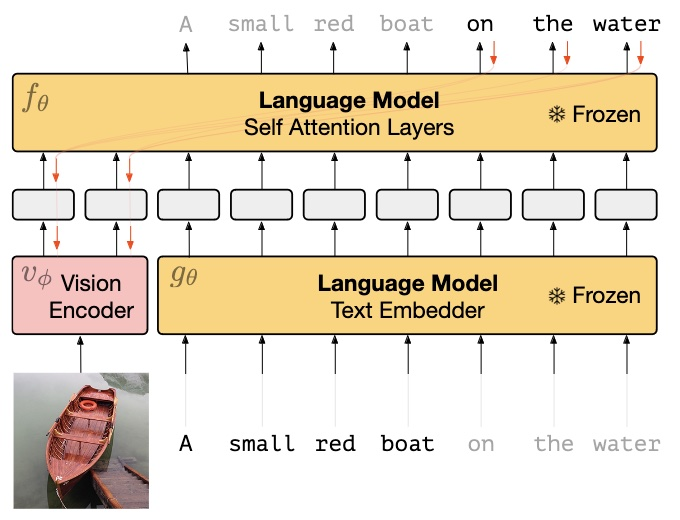

**Note:** You do not need to train this model or write training code for the model. Only demonstrate that you can pass an image + text and obtain text predictions from the model. You are free to use any computer vision model as the Vision Encoder (e.g. Resnet-50, ViT, the CLIP ViT encoder). Training would require (image + text, text) pairs for tuning the model. This could be a class project. Again, training not required. You are not allowed to use an external library or an existing implementation of this model. You are required to use the same LLM used in the previous sections of this assignment. Assume that the Text Embedder is just an nn.Embedding layer and for everything else keep things true to what is shown on this figure. Read the original technical paper if necessary.

In [ ]:
# Your code goes here.

## Note: Always stop your instance runtime to avoid running out of quotas:

In [ ]:
from google.colab import runtime
runtime.unassign()